In [1]:
import torch
import triton
from kernel_round_fp4 import round_to_fp4
from triton.tools.mxfp import MXFP4Tensor

In [2]:
# from triton.tools.mxfp import MXFP4Tensor

# x = torch.randn(2048, 2048, device="cuda") 
# # x = torch.tensor([0.25, 0.3, -0.3, 0.75, 1.25, 1.5, 2.5, 3.5, 5.0, 5.1, 7.0, -70]).cuda()
# # print(x)

# q1 = round_to_fp4(x)
# q2 = MXFP4Tensor(size=x.shape, data=x).data

# print(round_to_fp4_kernel.best_config)

# # _q1 = MXFP4Tensor(size=x.shape, device=x.device)
# # _q1.data = q1

# # q2.to(torch.float32), q1.to(torch.float32)


In [3]:
### TEST ###

# print(torch.all(q1 == q2))

# diff_mask = q1 != q2
# indices = torch.nonzero(diff_mask, as_tuple=False)

# for idx in indices:
#     idx_tuple = tuple(idx.tolist())
#     print(f"{x[idx_tuple[0], idx_tuple[1]]}: q1={q1[idx_tuple].item()}, q2={q2[idx_tuple].item()}")

Quantization time, ms:
        N      torch    kernel    matmul
0   512.0   4.222096  0.253728  0.168288
1  1024.0  12.534896  0.374784  0.831072
2  2048.0  45.036993  0.844224  8.256288


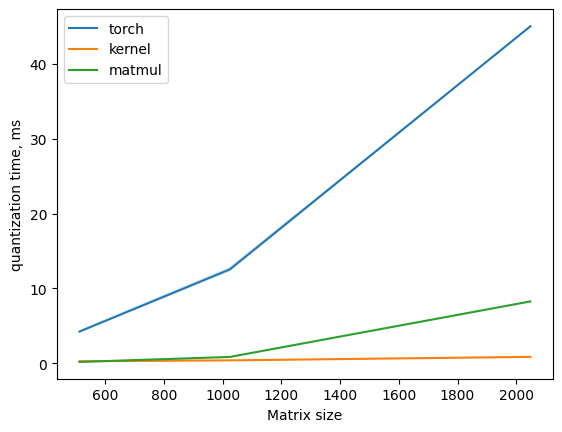

In [4]:
configs = []
configs.append(
    triton.testing.Benchmark(
        x_names=["N"],  # Argument names to use as an x-axis for the plot
        x_vals=[512, 1024, 2048], #, 4096, 8192],
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        line_vals=[
            "torch",
            "kernel",
            "matmul"
            ],
        line_names=[
            "torch",
            "kernel",
            "matmul" 
            ],
        ylabel="quantization time, ms",  # Label name for the y-axis
        xlabel="Matrix size",
        plot_name="Quantization time, ms",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    ))


### BENCHMARK ###
@triton.testing.perf_report(configs)
def benchmark(N, provider):
    x = 2 * torch.randn(N, N, dtype=torch.float32, device="cuda")

    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: MXFP4Tensor(size=x.shape, data=x), quantiles=quantiles)
    if provider == "matmul":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x @ x, quantiles=quantiles)
    if provider == "kernel":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: round_to_fp4(x), quantiles=quantiles)

    return ms, max_ms, min_ms

bench_data = benchmark.run(show_plots=False, print_data=True, return_df=True)

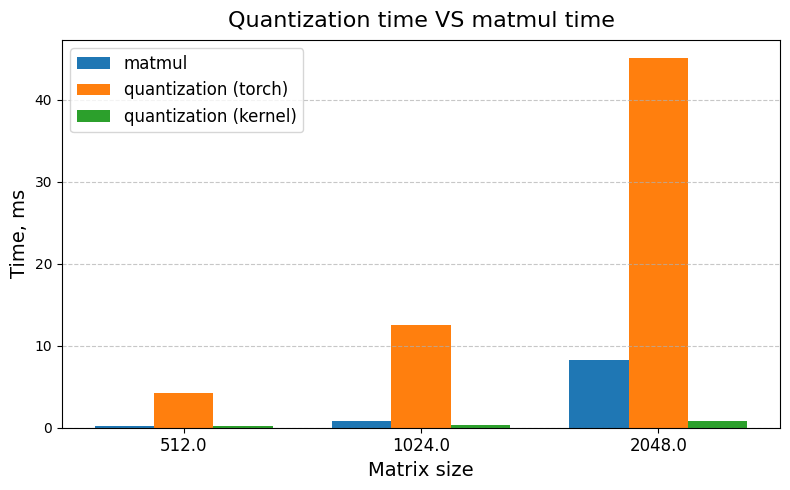

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(bench_data[0])

plt.figure(figsize=(8, 5))
width = 0.25
x = range(len(df))

plt.bar([i - width for i in x], df["matmul"], width=width, label="matmul")
plt.bar(x, df["torch"], width=width, label="quantization (torch)")
plt.bar([i + width for i in x], df["kernel"], width=width, label="quantization (kernel)")

plt.xticks(x, df["N"], fontsize=12)
plt.xlabel("Matrix size", fontsize=14)
plt.ylabel("Time, ms", fontsize=14)
plt.title("Quantization time VS matmul time", fontsize=16, pad=10)
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()